In [13]:
from itertools import product 

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture as GMM
from sklearn.metrics import silhouette_samples, silhouette_score, homogeneity_score
from sklearn.manifold import TSNE
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.compose import ColumnTransformer
from sklearn.random_projection import SparseRandomProjection

from scipy.linalg import pinv
import scipy.sparse as sps

In [14]:
## Loading the Data

bank_dataset = pd.read_csv('data/bank.csv', sep= ',', header=0)
bank_headers = list(bank_dataset)[:-1]
X_bank = bank_dataset.values[:,:-1]
y_bank = bank_dataset.values[:,-1]

letter_dataset = pd.read_csv('data/letter.csv', sep= ',', header=0)
letter_headers = list(letter_dataset)[:-1]
X_letter = letter_dataset.values[:,:-1]
y_letter = letter_dataset.values[:,-1]

seed = 0

## Letter

### Silhouette Method to determine k

In [26]:
def silhouettes(X, clusterer, range_n_clusters, g_title, em=False):

    for n_clusters in range_n_clusters:

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        plt.xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        plt.ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        if em:
            clusterer.set_params(n_components=n_clusters)
        else:
            clusterer.set_params(n_clusters=n_clusters)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            plt.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        plt.title(g_title + " - Silhouette plot with n_clusters = %d" % n_clusters)
        plt.xlabel("The silhouette coefficient values")
        plt.ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        plt.axvline(x=silhouette_avg, color="red", linestyle="--")

        plt.yticks([])  # Clear the yaxis labels / ticks
        plt.xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        
        plt.savefig('plots/silhouette/' + g_title + '/sil-for-' + str(n_clusters) + '-clusters.png')
        plt.show()
        
def silhouette_plot(cluster_method, range_n_clusters, X, title, random_state, path):
    
    silhouette_scores = []

    for n_clusters in range_n_clusters:

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        plt.xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        plt.ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        if cluster_method == "KMeans":
            clusterer = KMeans(n_clusters=n_clusters, random_state=random_state)
            cluster_labels = clusterer.fit_predict(X)
        elif cluster_method == "GMM":
            clusterer = GMM(n_components=n_clusters, covariance_type='full',random_state=random_state).fit(X)
            cluster_labels = clusterer.predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        silhouette_scores.append(silhouette_avg)

    max_idx = silhouette_scores.index(max(silhouette_scores))
    plt.clf()
    plt.plot(range_n_clusters, silhouette_scores, 'bx-')
    plt.plot(range_n_clusters[max_idx], silhouette_scores[max_idx], 'rx-')
    plt.title(title + " - Silhouette scores")
    plt.ylabel("Silhouette Score")
    plt.xlabel("Number of clusters")
    plt.savefig(path)
    plt.show()
    
def get_sum_squared_distances(X, clusterer, k_range):
    Sum_of_squared_distances = []
    for k in k_range:
        clusterer.set_params(n_clusters=k)
        km = clusterer.fit(X)
        Sum_of_squared_distances.append(km.inertia_)
    return Sum_of_squared_distances

def reconstruction_error(projections, x):
    w = projections.components_
    if sps.issparse(w):
        w = w.todense()
    p = pinv(w)
    reconstructed = ((p@w)@(x.T)).T  # Unproject projected data
    errors = np.square(x-reconstructed)
    return np.nanmean(errors)

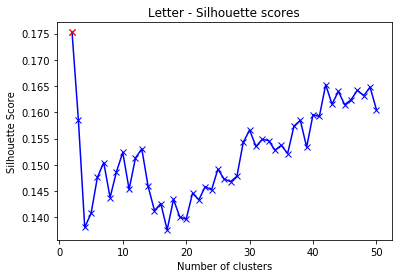

In [9]:
# silhouettes(X_letter, KMeans(n_clusters=2, random_state=seed), range(2,31), "Letter")
silhouette_plot("KMeans", range(2,51), X_letter, "Letter", seed, 'plots/default/Letter/summary-sil-kmeans.png')

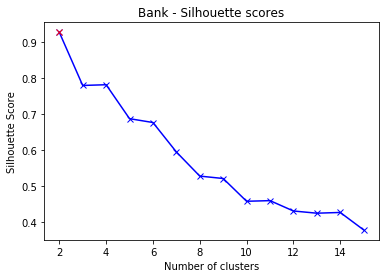

In [5]:
# silhouettes(X_bank, KMeans(n_clusters=2, random_state=seed), range(2, 16), "Bank")
silhouette_plot("KMeans", range(2,16), X_bank, "Bank", seed, 'plots/default/Bank/summary-sil-kmeans.png')

### Elbow Test

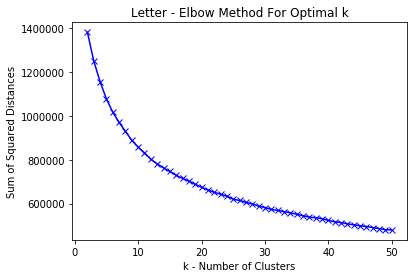

In [10]:
K = range(2, 51)
ssd = get_sum_squared_distances(X_letter, KMeans(n_clusters=2, random_state=seed), K)
plt.plot(K, ssd, 'bx-')
plt.xlabel('k - Number of Clusters')
plt.ylabel('Sum of Squared Distances')
plt.title('Letter - Elbow Method For Optimal k')
plt.savefig('plots/default/Letter/ssd.png')
plt.show()

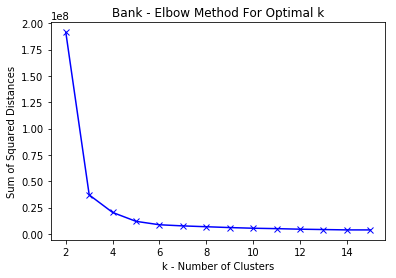

In [7]:
K = range(2, 16)
ssd = get_sum_squared_distances(X_bank, KMeans(n_clusters=2, random_state=seed), K)
plt.plot(K, ssd, 'bx-')
plt.xlabel('k - Number of Clusters')
plt.ylabel('Sum of Squared Distances')
plt.title('Bank - Elbow Method For Optimal k')
plt.savefig('plots/default/Bank/ssd.png')
plt.show()

## Finding # of components for EM

### Letter

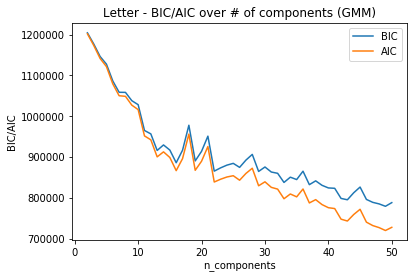

In [11]:
n_components = np.arange(2, 51)
models = [GMM(n, covariance_type='full', random_state=seed).fit(X_letter)
          for n in n_components]

plt.title("Letter - BIC/AIC over # of components (GMM)")
plt.plot(n_components, [m.bic(X_letter) for m in models], label='BIC')
plt.plot(n_components, [m.aic(X_letter) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.ylabel('BIC/AIC')
plt.savefig('plots/default/Letter/bic-aic.png')
plt.show()

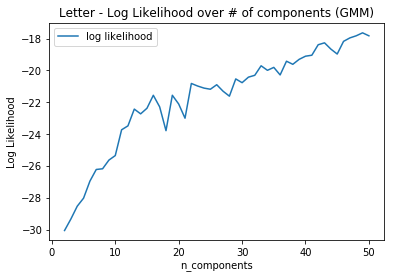

In [12]:
plt.title("Letter - Log Likelihood over # of components (GMM)")
plt.plot(n_components, [m.score(X_letter) for m in models], label='log likelihood')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.ylabel('Log Likelihood')
plt.savefig('plots/default/Letter/loglik.png')
plt.show()

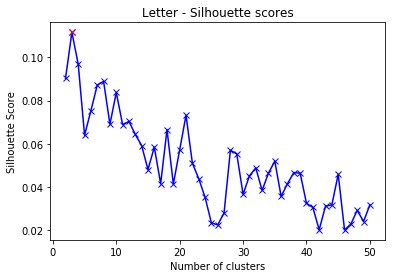

In [19]:
silhouette_plot("GMM", range(2,51), X_letter, "Letter", seed, 'plots/default/Letter/summary-sil-gmm.png')

### Bank

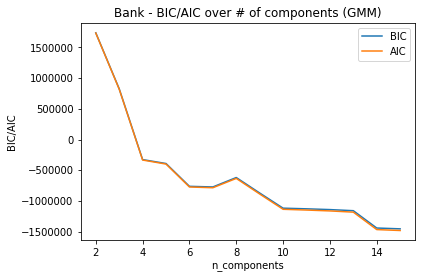

In [13]:
n_components = np.arange(2, 16)
models = [GMM(n, covariance_type='full', random_state=seed).fit(X_bank)
          for n in n_components]

plt.title("Bank - BIC/AIC over # of components (GMM)")
plt.plot(n_components, [m.bic(X_bank) for m in models], label='BIC')
plt.plot(n_components, [m.aic(X_bank) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.ylabel('BIC/AIC')
plt.savefig('plots/default/Bank/bic-aic.png')
plt.show()

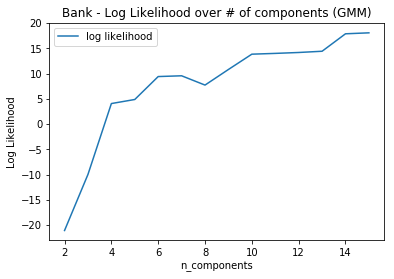

In [14]:
plt.title("Bank - Log Likelihood over # of components (GMM)")
plt.plot(n_components, [m.score(X_bank) for m in models], label='log likelihood')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.ylabel('Log Likelihood')
plt.savefig('plots/default/Bank/loglik.png')
plt.show()

## Visualizing the Cluster Results

### Letter

In [15]:
training_x2D_let = TSNE(verbose=False, random_state=seed).fit_transform(X_letter)

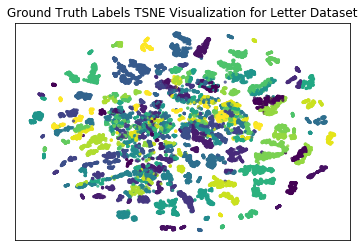

In [16]:
df = pd.DataFrame(np.hstack((training_x2D_let, np.atleast_2d(y_letter).T)), columns=['x','y','target'])
possible_clusters = list(set(df['target']))

plt.gca()
plt.title("Ground Truth Labels TSNE Visualization for Letter Dataset")
plt.scatter(df['x'], df['y'], c=df['target'], alpha=0.7, s=5)
plt.xticks([])
plt.yticks([])
plt.grid(None)
plt.axis('tight')
plt.savefig('plots/default/Letter/TSNE-groundtruth.png')
plt.show()

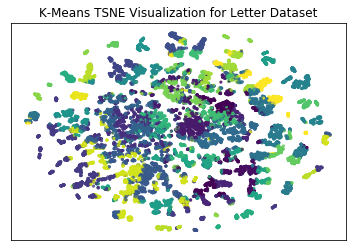

In [17]:
km = KMeans(n_clusters=30, init='k-means++', random_state=seed)
km = km.fit(X_letter)
y_pred_letter = km.labels_

df = pd.DataFrame(np.hstack((training_x2D_let, np.atleast_2d(y_pred_letter).T)), columns=['x','y','target'])
possible_clusters = list(set(df['target']))

plt.gca()
plt.title("K-Means TSNE Visualization for Letter Dataset")
plt.scatter(df['x'], df['y'], c=df['target'], alpha=0.7, s=5)
plt.xticks([])
plt.yticks([])
plt.grid(None)
plt.axis('tight')
plt.savefig('plots/default/Letter/TSNE-kmeans.png')
plt.show()

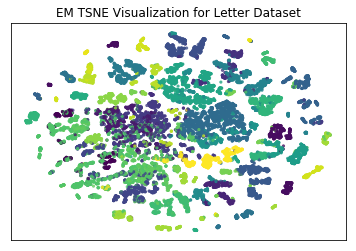

In [21]:
gmm = GMM(n_components=30, covariance_type='full', random_state=seed)
gmm = gmm.fit(X_letter)
y_pred_letter = gmm.predict(X_letter)

df = pd.DataFrame(np.hstack((training_x2D_let, np.atleast_2d(y_pred_letter).T)), columns=['x','y','target'])
possible_clusters = list(set(df['target']))

plt.gca()
plt.title("EM TSNE Visualization for Letter Dataset")
plt.scatter(df['x'], df['y'], c=df['target'], alpha=0.7, s=5)
plt.xticks([])
plt.yticks([])
plt.grid(None)
plt.axis('tight')
plt.savefig('plots/default/Letter/TSNE-gmm.png')
plt.show()

In [22]:
training_x2D_bank = TSNE(verbose=False, random_state=seed).fit_transform(X_bank)

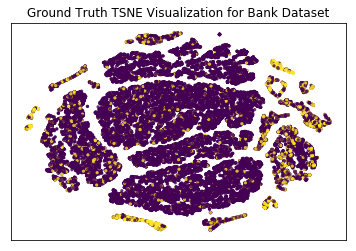

In [23]:
df = pd.DataFrame(np.hstack((training_x2D_bank, np.atleast_2d(y_bank).T)), columns=['x','y','target'])
possible_clusters = list(set(df['target']))

plt.gca()
plt.title("Ground Truth TSNE Visualization for Bank Dataset")
plt.scatter(df['x'], df['y'], c=df['target'], alpha=0.7, s=5)
plt.xticks([])
plt.yticks([])
plt.grid(None)
plt.axis('tight')
plt.savefig('plots/default/Bank/TSNE-groundtruth.png')
plt.show()

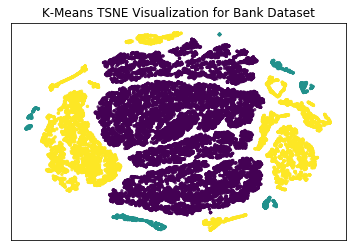

In [24]:
km = KMeans(n_clusters=3, init='k-means++', random_state=seed)
km = km.fit(X_bank)
y_pred_bank = km.labels_

df = pd.DataFrame(np.hstack((training_x2D_bank, np.atleast_2d(y_pred_bank).T)), columns=['x','y','target'])
possible_clusters = list(set(df['target']))

plt.gca()
plt.title("K-Means TSNE Visualization for Bank Dataset")
plt.scatter(df['x'], df['y'], c=df['target'], alpha=0.7, s=5)
plt.xticks([])
plt.yticks([])
plt.grid(None)
plt.axis('tight')
plt.savefig('plots/default/Bank/TSNE-kmeans.png')
plt.show()

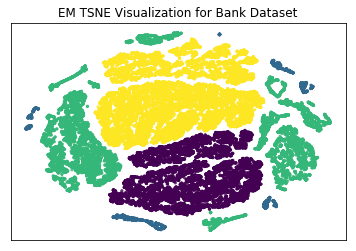

In [25]:
gmm = GMM(n_components=4, covariance_type='full', random_state=seed)
gmm = gmm.fit(X_bank)
y_pred_bank = gmm.predict(X_bank)

df = pd.DataFrame(np.hstack((training_x2D_bank, np.atleast_2d(y_pred_bank).T)), columns=['x','y','target'])
possible_clusters = list(set(df['target']))

plt.gca()
plt.title("EM TSNE Visualization for Bank Dataset")
plt.scatter(df['x'], df['y'], c=df['target'], alpha=0.7, s=5)
plt.xticks([])
plt.yticks([])
plt.grid(None)
plt.axis('tight')
plt.savefig('plots/default/Bank/TSNE-gmm.png')
plt.show()

## PCA Letter Experiments

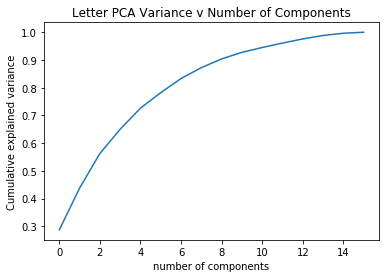

In [165]:
pca = PCA().fit(X_letter)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title("Letter PCA Variance v Number of Components")
plt.xlabel('number of components')
plt.ylabel('Cumulative explained variance')
plt.savefig('plots/PCA/Letter/explained-variance.png')
plt.show()

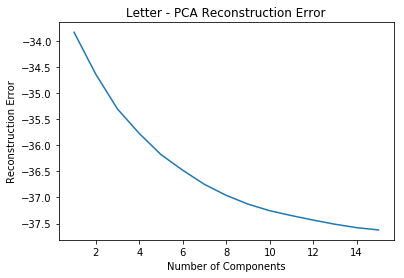

In [164]:
recon_error = []

for i in range(1, X_letter.shape[1]):
    pca = PCA(n_components=i)
    pca_projected_letter = pca.fit_transform(X_letter)
    error = (X_letter - pca.inverse_transform(pca_projected_letter) ** 2).mean()
    recon_error.append(error)
    
plt.plot(range(1, X_letter.shape[1]), recon_error)

plt.title('Letter - PCA Reconstruction Error')
plt.ylabel('Reconstruction Error')
plt.xlabel('Number of Components')
plt.savefig('plots/PCA/Letter/reconstructionerror.png')
plt.show()

(20000, 16)
(20000, 2)


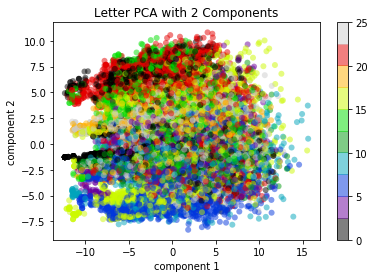

In [28]:
pca = PCA(n_components=2) # project from 15 to 2 dimensions
pca_projected_let = pca.fit_transform(X_letter)
print(X_letter.shape)
print(pca_projected_let.shape)

plt.scatter(pca_projected_let[:, 0], pca_projected_let[:, 1],
            c=y_letter, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.title("Letter PCA with 2 Components")
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar()
plt.savefig('plots/PCA/Letter/scatter-2dimpca.png')
plt.show()

In [30]:
pca = PCA(n_components=12) # project from 15 to 7 dimensions
pca_X_letter = pca.fit_transform(X_letter)
print(X_letter.shape)
print(pca_X_letter.shape)

(20000, 16)
(20000, 12)


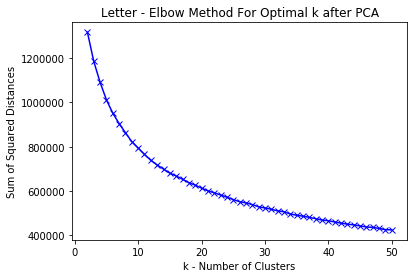

In [31]:
K = range(2, 51)
ssd = get_sum_squared_distances(pca_X_letter, KMeans(n_clusters=2, random_state=seed), K)
plt.plot(K, ssd, 'bx-')
plt.xlabel('k - Number of Clusters')
plt.ylabel('Sum of Squared Distances')
plt.title('Letter - Elbow Method For Optimal k after PCA')
plt.savefig('plots/PCA/Letter/ssd.png')
plt.show()

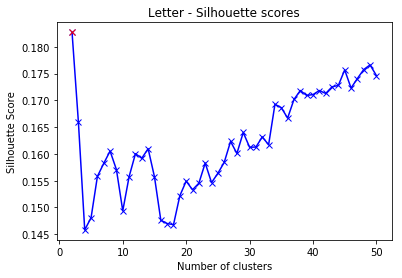

In [32]:
# silhouettes(pca_X_letter, KMeans(n_clusters=2, random_state=seed), range(2,31), "Letter-PCA-KMeans")
silhouette_plot("KMeans", range(2,51), pca_X_letter, "Letter", seed, 'plots/PCA/Letter/summary-sil-kmeans.png')

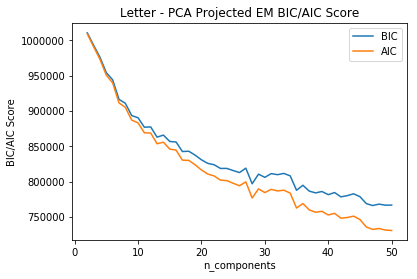

In [33]:
n_components = np.arange(2, 51)
models = [GMM(n, covariance_type='full', random_state=seed).fit(pca_X_letter)
          for n in n_components]

plt.plot(n_components, [m.bic(pca_X_letter) for m in models], label='BIC')
plt.plot(n_components, [m.aic(pca_X_letter) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.ylabel('BIC/AIC Score')
plt.title('Letter - PCA Projected EM BIC/AIC Score')
plt.savefig('plots/PCA/Letter/aic-bic.png')
plt.show()

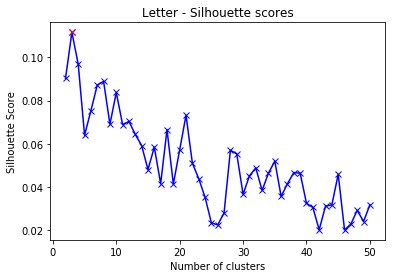

In [34]:
# range_n_clusters = range(2,31)
# silhouettes(pca_X_letter, GMM(n_components=2, covariance_type='full', random_state=seed), range(2,31), "Letter-PCA-GMM", em=True)
silhouette_plot("GMM", range(2,51), X_letter, "Letter", seed, 'plots/PCA/Letter/summary-sil-gmm.png')

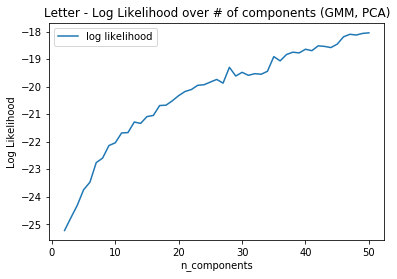

In [35]:
n_components = np.arange(2, 51)
models = [GMM(n, covariance_type='full', random_state=seed).fit(pca_X_letter)
          for n in n_components]

plt.title("Letter - Log Likelihood over # of components (GMM, PCA)")
plt.plot(n_components, [m.score(pca_X_letter) for m in models], label='log likelihood')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.ylabel('Log Likelihood')
plt.savefig('plots/PCA/Letter/loglik.png')
plt.show()

In [36]:
# #############################################################################
# Visualize the results on PCA-reduced data

pca = PCA(n_components=2) # project from 15 to 2 dimensions
reduced_data = pca.fit_transform(X_letter)
n_letters = 21
kmeans = KMeans(init='k-means++', n_clusters=n_letters, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)

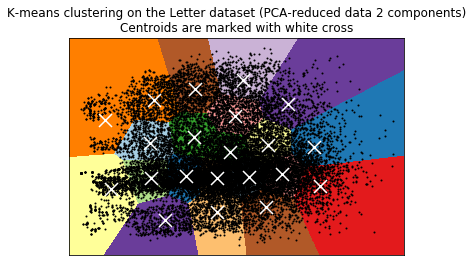

In [37]:
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the Letter dataset (PCA-reduced data 2 components)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.savefig('plots/PCA/Letter/centroids.png')
plt.show()

In [38]:
training_x2D_letter_PCA = TSNE(verbose=False, random_state=seed).fit_transform(pca_X_letter)

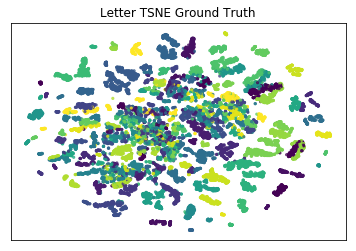

In [45]:
ds_2d = pd.DataFrame(np.hstack((training_x2D_letter_PCA, np.atleast_2d(y_letter).T)),
                             columns=['x', 'y', 'target'])
df = ds_2d
possible_clusters = list(set(df['target']))

plt.gca()
plt.title("Letter TSNE Ground Truth")
plt.scatter(df['x'], df['y'], c=df['target'], alpha=0.7, s=5)
plt.xticks([])
plt.yticks([])
plt.grid(None)
plt.axis('tight')
plt.savefig('plots/PCA/Letter/TSNE-groundtruth.png')
plt.show()

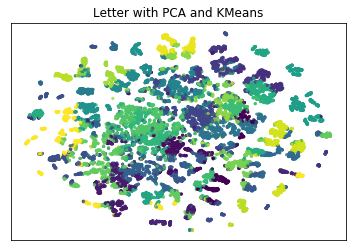

In [46]:
n_letters = 33
kmeans = KMeans(init='k-means++', n_clusters=n_letters, random_state=seed)
kmeans.fit(pca_X_letter)

ds_2d = pd.DataFrame(np.hstack((training_x2D_letter_PCA, np.atleast_2d(kmeans.labels_).T)),
                             columns=['x', 'y', 'target'])
df = ds_2d
possible_clusters = list(set(df['target']))

plt.gca()
plt.title("Letter with PCA and KMeans")
plt.scatter(df['x'], df['y'], c=df['target'], alpha=0.7, s=5)
plt.xticks([])
plt.yticks([])
plt.grid(None)
plt.axis('tight')
plt.savefig('plots/PCA/Letter/TSNE-kmeans.png')
plt.show()

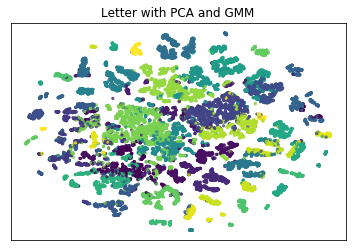

In [47]:
n_letters = 28
gmm = GMM(n_components=n_letters, random_state=seed)
gmm = gmm.fit(pca_X_letter)

ds_2d = pd.DataFrame(np.hstack((training_x2D_letter_PCA, np.atleast_2d(gmm.predict(pca_X_letter)).T)),
                             columns=['x', 'y', 'target'])
df = ds_2d
possible_clusters = list(set(df['target']))

plt.gca()
plt.title("Letter with PCA and GMM")
plt.scatter(df['x'], df['y'], c=df['target'], alpha=0.7, s=5)
plt.xticks([])
plt.yticks([])
plt.grid(None)
plt.axis('tight')
plt.savefig('plots/PCA/Letter/TSNE-em.png')
plt.show()

## PCA Bank Experiments

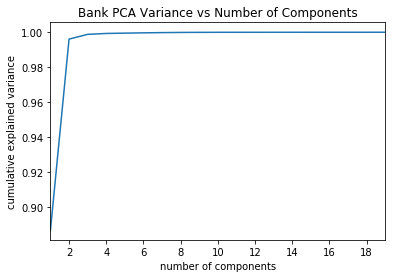

In [55]:
pca = PCA().fit(X_bank)
plt.plot(np.arange(1, X_bank.shape[1]+1), np.cumsum(pca.explained_variance_ratio_), label='CEV')
plt.title("Bank PCA Variance vs Number of Components")
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.xlim(1, X_bank.shape[1])
plt.savefig('plots/PCA/Bank/explained-variance.png')
plt.show()

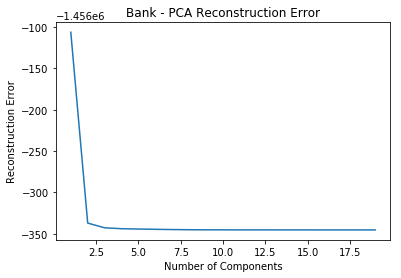

In [160]:
recon_error = []

for i in range(1, X_bank.shape[1]+1):
    pca = PCA(n_components=i)
    pca_projected_bank = pca.fit_transform(X_bank)
    error = (X_bank - pca.inverse_transform(pca_projected_bank) ** 2).mean()
    recon_error.append(error)
    
plt.plot(range(1, X_bank.shape[1]+1), recon_error)

plt.title('Bank - PCA Reconstruction Error')
plt.ylabel('Reconstruction Error')
plt.xlabel('Number of Components')
plt.savefig('plots/PCA/Bank/reconstructionerror.png')
plt.show()

In [56]:
pca = PCA(n_components=4) # project from 19 to 4 dimensions
pca_X_bank = pca.fit_transform(X_bank)
print(X_bank.shape)
print(pca_X_bank.shape)

(41188, 19)
(41188, 4)


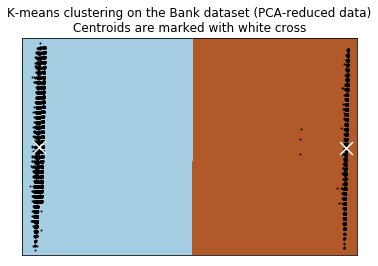

In [12]:
reduced_data = PCA(n_components=2).fit_transform(X_bank[:24000])
kmeans = KMeans(init='k-means++', n_clusters=2, n_init=2)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the Bank dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.savefig('plots/PCA/Bank/centroids.png')
plt.show()

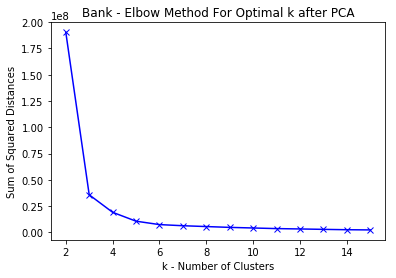

In [58]:
K = range(2,16)
ssd = get_sum_squared_distances(pca_X_bank, KMeans(n_clusters=2), K)
plt.plot(K, ssd, 'bx-')
plt.xlabel('k - Number of Clusters')
plt.ylabel('Sum of Squared Distances')
plt.title('Bank - Elbow Method For Optimal k after PCA')
plt.savefig('plots/PCA/Bank/ssd.png')
plt.show()

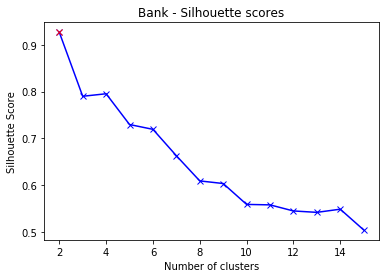

In [64]:
# silhouettes(pca_X_bank, KMeans(n_components=2, random_state=seed), range(2,16), "Bank-PCA-KMeans")
silhouette_plot("KMeans", range(2,16), pca_X_bank, "Bank", seed, 'plots/PCA/Bank/summary-sil-kmeans.png')

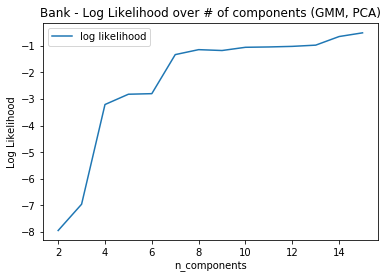

In [62]:
n_components = np.arange(2, 16)
models = [GMM(n, covariance_type='full', random_state=seed).fit(pca_X_bank)
          for n in n_components]

plt.title("Bank - Log Likelihood over # of components (GMM, PCA)")
plt.plot(n_components, [m.score(pca_X_bank) for m in models], label='log likelihood')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.ylabel('Log Likelihood')
plt.savefig('plots/PCA/Bank/loglik.png')
plt.show()

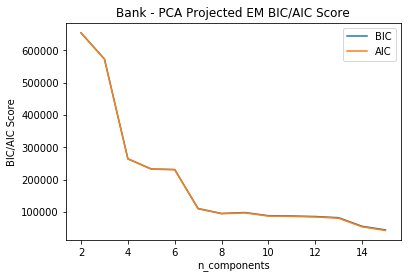

In [63]:
plt.plot(n_components, [m.bic(pca_X_bank) for m in models], label='BIC')
plt.plot(n_components, [m.aic(pca_X_bank) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.ylabel('BIC/AIC Score')
plt.title('Bank - PCA Projected EM BIC/AIC Score')
plt.savefig('plots/PCA/Bank/aic-bic.png')
plt.show()

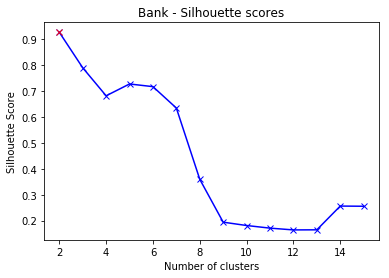

In [65]:
silhouette_plot("GMM", range(2,16), pca_X_bank, "Bank", seed, 'plots/PCA/Bank/summary-sil-gmm.png')

In [66]:
training_x2D_bank_pca = TSNE(verbose=False, random_state=10).fit_transform(pca_X_bank)

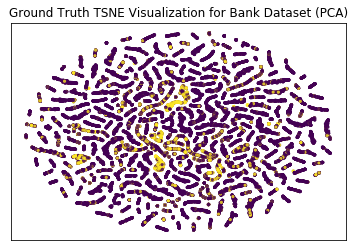

In [67]:
df = pd.DataFrame(np.hstack((training_x2D_bank_pca, np.atleast_2d(y_bank).T)), columns=['x','y','target'])
possible_clusters = list(set(df['target']))

plt.gca()
plt.title("Ground Truth TSNE Visualization for Bank Dataset (PCA)")
plt.scatter(df['x'], df['y'], c=df['target'], alpha=0.7, s=5)
plt.xticks([])
plt.yticks([])
plt.grid(None)
plt.axis('tight')
plt.savefig('plots/PCA/Bank/TSNE-groundtruth.png')
plt.show()

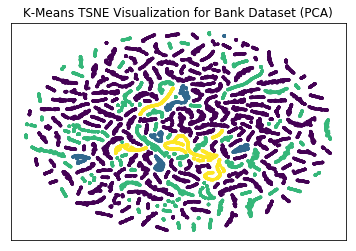

In [69]:
km = KMeans(n_clusters=4, init='k-means++',random_state=seed)
km = km.fit(pca_X_bank)
y_pred_bank = km.labels_

df = pd.DataFrame(np.hstack((training_x2D_bank_pca, np.atleast_2d(y_pred_bank).T)), columns=['x','y','target'])
possible_clusters = list(set(df['target']))

plt.gca()
plt.title("K-Means TSNE Visualization for Bank Dataset (PCA)")
plt.scatter(df['x'], df['y'], c=df['target'], alpha=0.7, s=5)
plt.xticks([])
plt.yticks([])
plt.grid(None)
plt.axis('tight')
plt.savefig('plots/PCA/Bank/TSNE-kmeans.png')

plt.show()

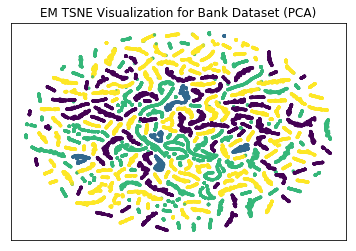

In [70]:
gmm = GMM(n_components=5, covariance_type='full', random_state=seed)
gmm = gmm.fit(pca_X_bank)
y_pred_bank = gmm.predict(pca_X_bank)

df = pd.DataFrame(np.hstack((training_x2D_bank_pca, np.atleast_2d(y_pred_bank).T)), columns=['x','y','target'])
possible_clusters = list(set(df['target']))

plt.gca()
plt.title("EM TSNE Visualization for Bank Dataset (PCA)")
plt.scatter(df['x'], df['y'], c=df['target'], alpha=0.7, s=5)
plt.xticks([])
plt.yticks([])
plt.grid(None)
plt.axis('tight')
plt.savefig('plots/PCA/Bank/TSNE-em.png')
plt.show()

# ICA Experiments

In [16]:
ica = FastICA(random_state=seed, max_iter=10000)
kurt_letter = {}
for dim in range(2,X_letter.shape[1]+1):
    ica.set_params(n_components=dim)
    tmp = ica.fit_transform(X_letter)
    tmp = pd.DataFrame(tmp)
    tmp = tmp.kurt(axis=0)
    kurt_letter[dim] = tmp.abs().mean()

kurt_letter = pd.Series(kurt_letter)

C:\Users\Benny\Miniconda3\lib\site-packages\sklearn\decomposition\fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


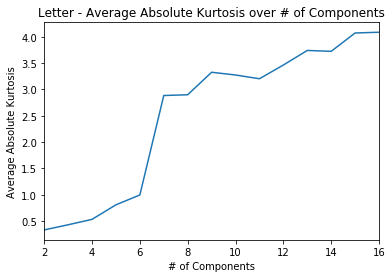

In [17]:
plt.xlabel('# of Components')
plt.ylabel('Average Absolute Kurtosis')
plt.xlim(2,X_letter.shape[1])
plt.title('Letter - Average Absolute Kurtosis over # of Components')
plt.plot(kurt_letter)
plt.savefig('plots/ICA/Letter/kurtosis.png')
plt.show()

In [18]:
ica = FastICA(n_components = 9, random_state=seed, max_iter=50000) # project from 15 to 9 dims
ica_X_letter = ica.fit_transform(X_letter)
print(X_letter.shape)
print(ica_X_letter.shape)

(20000, 16)
(20000, 9)


In [19]:
ica = FastICA(random_state=seed, max_iter=50000)
kurt_bank = {}
for dim in range(2,X_bank.shape[1]+1):
    ica.set_params(n_components=dim)
    tmp = ica.fit_transform(X_bank)
    tmp = pd.DataFrame(tmp)
    tmp = tmp.kurt(axis=0)
    kurt_bank[dim] = tmp.abs().mean()

kurt_bank = pd.Series(kurt_bank)

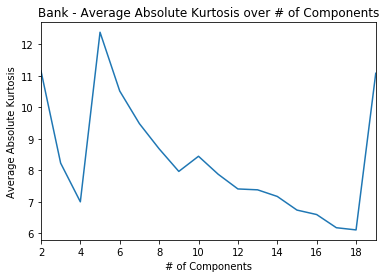

In [20]:
plt.xlabel('# of Components')
plt.ylabel('Average Absolute Kurtosis')
plt.xlim(2,X_bank.shape[1])
plt.title('Bank - Average Absolute Kurtosis over # of Components')
plt.plot(kurt_bank)
plt.savefig('plots/ICA/Bank/kurtosis.png')
plt.show()

In [78]:
ica = FastICA(n_components = 5, random_state=seed, max_iter=50000) # project from 15 to 2 dims
ica_X_bank = ica.fit_transform(X_bank)
print(X_bank.shape)
print(ica_X_bank.shape)

(41188, 19)
(41188, 5)


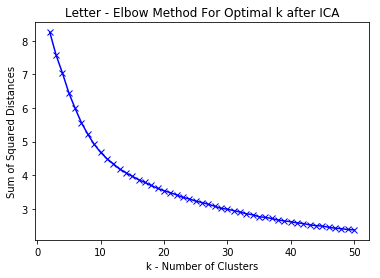

In [144]:
K = range(2, 51)
ssd = get_sum_squared_distances(ica_X_letter, KMeans(n_clusters=2), K)
plt.plot(K, ssd, 'bx-')
plt.xlabel('k - Number of Clusters')
plt.ylabel('Sum of Squared Distances')
plt.title('Letter - Elbow Method For Optimal k after ICA')
plt.savefig('plots/ICA/Letter/ssd.png')
plt.show()

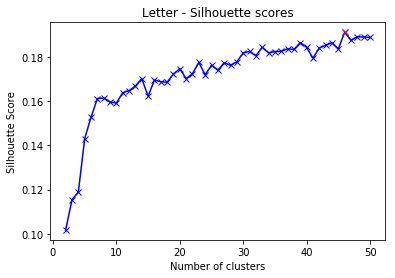

In [145]:
silhouette_plot("KMeans", range(2,51), ica_X_letter, "Letter", seed, 'plots/ICA/Letter/summary-sil-kmeans.png')

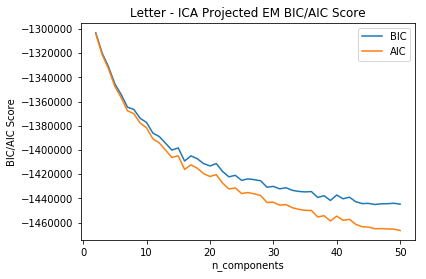

In [146]:
n_components = np.arange(2, 51)
models = [GMM(n, covariance_type='full').fit(ica_X_letter)
          for n in n_components]

plt.plot(n_components, [m.bic(ica_X_letter) for m in models], label='BIC')
plt.plot(n_components, [m.aic(ica_X_letter) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.ylabel('BIC/AIC Score')
plt.title('Letter - ICA Projected EM BIC/AIC Score')
plt.savefig('plots/ICA/Letter/aic-bic.png')
plt.show()

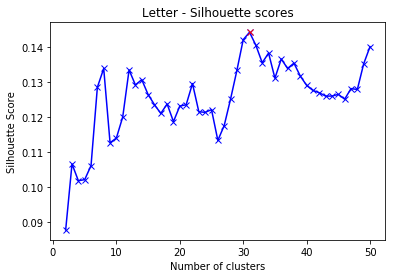

In [147]:
# silhouettes(ica_X_letter, GMM(n_components=2, covariance_type='full', random_state=seed), range(2,31), "Letter-ICA-GMM", em=True)
path = 'plots/ICA/Letter/sil-summary.png'
silhouette_plot("GMM", range(2,51), ica_X_letter, "Letter", seed, path)

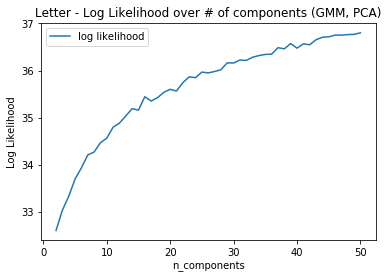

In [148]:
plt.title("Letter - Log Likelihood over # of components (GMM, PCA)")
plt.plot(n_components, [m.score(ica_X_letter) for m in models], label='log likelihood')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.ylabel('Log Likelihood')
plt.savefig('plots/ICA/Letter/loglik.png')
plt.show()

In [149]:
training_x2D_letter_ICA = TSNE(verbose=False, random_state=seed).fit_transform(ica_X_letter)

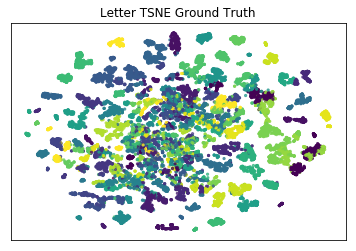

In [150]:
ds_2d = pd.DataFrame(np.hstack((training_x2D_letter_ICA, np.atleast_2d(y_letter).T)),
                             columns=['x', 'y', 'target'])
df = ds_2d
possible_clusters = list(set(df['target']))

plt.gca()
plt.title("Letter TSNE Ground Truth")
plt.scatter(df['x'], df['y'], c=df['target'], alpha=0.7, s=5)
plt.xticks([])
plt.yticks([])
plt.grid(None)
plt.axis('tight')
plt.savefig('plots/ICA/Letter/TSNE-groundtruth.png')
plt.show()

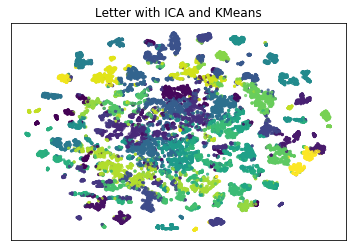

In [92]:
n_letters = 45
kmeans = KMeans(init='k-means++', n_clusters=n_letters, n_init=10)
kmeans.fit(ica_X_letter)

ds_2d = pd.DataFrame(np.hstack((training_x2D_letter_ICA, np.atleast_2d(kmeans.labels_).T)),
                             columns=['x', 'y', 'target'])
df = ds_2d
possible_clusters = list(set(df['target']))

plt.gca()
plt.title("Letter with ICA and KMeans")
plt.scatter(df['x'], df['y'], c=df['target'], alpha=0.7, s=5)
plt.xticks([])
plt.yticks([])
plt.grid(None)
plt.axis('tight')
plt.savefig('plots/ICA/Letter/TSNE-kmeans.png')
plt.show()

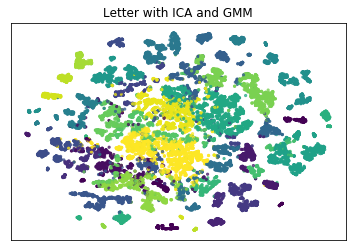

In [151]:
n_letters = 31
gmm = GMM(n_components=n_letters)
gmm = gmm.fit(ica_X_letter)

ds_2d = pd.DataFrame(np.hstack((training_x2D_letter_ICA, np.atleast_2d(gmm.predict(ica_X_letter)).T)),
                             columns=['x', 'y', 'target'])
df = ds_2d
possible_clusters = list(set(df['target']))

plt.gca()
plt.title("Letter with ICA and GMM")
plt.scatter(df['x'], df['y'], c=df['target'], alpha=0.7, s=5)
plt.xticks([])
plt.yticks([])
plt.grid(None)
plt.axis('tight')
plt.savefig('plots/ICA/Letter/TSNE-em.png')
plt.show()

## Finding k for Bank ICA

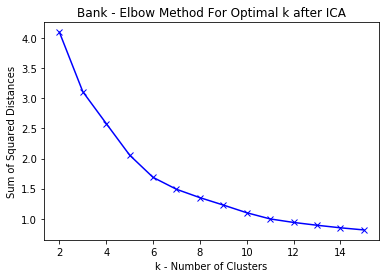

In [96]:
K = range(2,16)
ssd = get_sum_squared_distances(ica_X_bank, KMeans(n_clusters=2, random_state=seed), K)
plt.plot(K, ssd, 'bx-')
plt.xlabel('k - Number of Clusters')
plt.ylabel('Sum of Squared Distances')
plt.title('Bank - Elbow Method For Optimal k after ICA')
plt.savefig('plots/ICA/Bank/ssd.png')
plt.show()

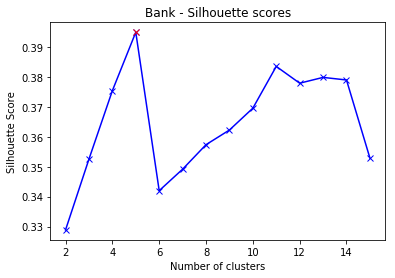

In [107]:
# silhouettes(ica_X_bank, KMeans(n_clusters=2, random_state=seed), range(2,16), "Bank-ICA-KMeans")
path = 'plots/ICA/Bank/sil-summary.png'
silhouette_plot("KMeans", range(2,16), ica_X_bank, "Bank", seed, path)

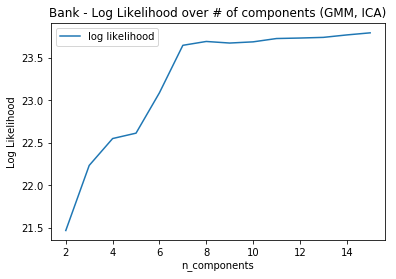

In [97]:
n_components = np.arange(2, 16)
models = [GMM(n, covariance_type='full', random_state=seed).fit(ica_X_bank)
          for n in n_components]

plt.title("Bank - Log Likelihood over # of components (GMM, ICA)")
plt.plot(n_components, [m.score(ica_X_bank) for m in models], label='log likelihood')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.ylabel('Log Likelihood')
plt.savefig('plots/ICA/Bank/loglik.png')
plt.show()

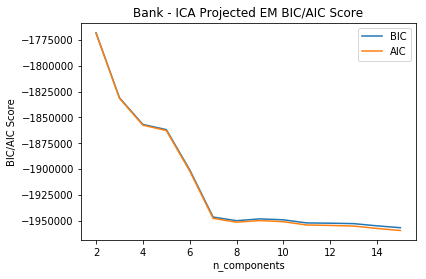

In [98]:
plt.plot(n_components, [m.bic(ica_X_bank) for m in models], label='BIC')
plt.plot(n_components, [m.aic(ica_X_bank) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.ylabel('BIC/AIC Score')
plt.title('Bank - ICA Projected EM BIC/AIC Score')
plt.savefig('plots/ICA/Bank/aic-bic.png')
plt.show()

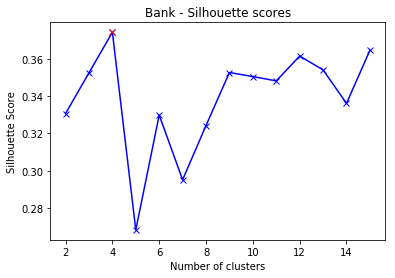

In [108]:
path = 'plots/ICA/Bank/sil-summary-gmm.png'
silhouette_plot("GMM", range(2,16), ica_X_bank, "Bank", seed, path)

In [100]:
training_x2D_bank_ICA = TSNE(verbose=False, random_state=seed).fit_transform(ica_X_bank)

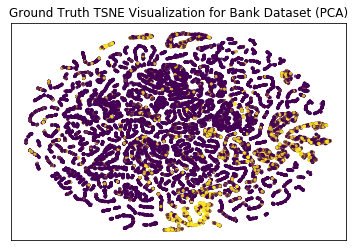

In [101]:
df = pd.DataFrame(np.hstack((training_x2D_bank_ICA, np.atleast_2d(y_bank).T)), columns=['x','y','target'])
possible_clusters = list(set(df['target']))

plt.gca()
plt.title("Ground Truth TSNE Visualization for Bank Dataset (PCA)")
plt.scatter(df['x'], df['y'], c=df['target'], alpha=0.7, s=5)
plt.xticks([])
plt.yticks([])
plt.grid(None)
plt.axis('tight')
plt.savefig('plots/TSNE-groundtruth-bank-ica.png')
plt.show()

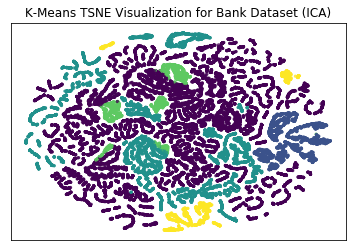

In [110]:
km = KMeans(n_clusters=5, init='k-means++', random_state=seed)
km = km.fit(ica_X_bank)
y_pred_bank = km.labels_

df = pd.DataFrame(np.hstack((training_x2D_bank_ICA, np.atleast_2d(y_pred_bank).T)), columns=['x','y','target'])
possible_clusters = list(set(df['target']))

plt.gca()
plt.title("K-Means TSNE Visualization for Bank Dataset (ICA)")
plt.scatter(df['x'], df['y'], c=df['target'], alpha=0.7, s=5)
plt.xticks([])
plt.yticks([])
plt.grid(None)
plt.axis('tight')
plt.savefig('plots/TSNE-kmeans-bank-ica.png')

plt.show()

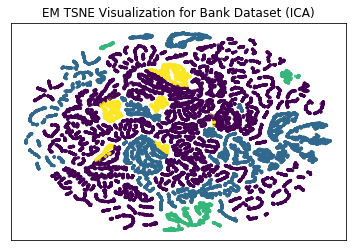

In [111]:
gmm = GMM(n_components=4, covariance_type='full', random_state=seed)
gmm = gmm.fit(ica_X_bank)
y_pred_bank = gmm.predict(ica_X_bank)

df = pd.DataFrame(np.hstack((training_x2D_bank_ICA, np.atleast_2d(y_pred_bank).T)), columns=['x','y','target'])
possible_clusters = list(set(df['target']))

plt.gca()
plt.title("EM TSNE Visualization for Bank Dataset (ICA)")
plt.scatter(df['x'], df['y'], c=df['target'], alpha=0.7, s=5)
plt.xticks([])
plt.yticks([])
plt.grid(None)
plt.axis('tight')
plt.savefig('plots/TSNE-em-bank-ica.png')
plt.show()

## Randomized Projection

### Letter

In [22]:
num_seeds = 10
ran_X_letter_dict = {}
for i in range(num_seeds):
    ran_X_letter_dict[i] = []
    
for state, dim in product(range(num_seeds), range(1, X_letter.shape[1]+1)):
    rp = SparseRandomProjection(random_state=state, n_components=dim)
    ran_X_letter_dict[state].append(rp.fit_transform(X_letter))

In [23]:
accuracies_letter = {}
for i in range(len(ran_X_letter_dict)):
    accuracies_letter[i] = []
    
n_feats = np.arange(1,X_letter.shape[1]+1)
for i in range(len(ran_X_letter_dict)):
    for X in ran_X_letter_dict[i]:
        acc = np.mean(cross_val_score(DecisionTreeClassifier(), X, y_letter, cv=20))
        accuracies_letter[i].append(acc)

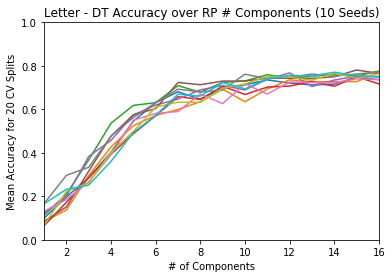

In [24]:
for i in range(len(accuracies_letter)):
    plt.plot(range(1,X_letter.shape[1]+1), accuracies_letter[i], label='Run ' + str(i))

plt.title('Letter - DT Accuracy over RP # Components (10 Seeds)')
plt.ylabel('Mean Accuracy for 20 CV Splits')
plt.xlabel('# of Components')
plt.ylim(0,1)
plt.xlim(1,X_letter.shape[1])
plt.savefig('plots/RP/Letter/dt-component-analysis.png')
plt.show()

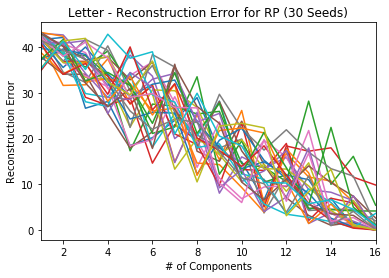

In [28]:
num_seeds = 30
recon_error = {}
for i in range(num_seeds):
    recon_error[i] = []
    
for state, dim in product(range(num_seeds), range(1, X_letter.shape[1]+1)):
        rp = SparseRandomProjection(n_components=dim, random_state=state)
        rp.fit(X_letter)
        recon_error[state].append(reconstruction_error(rp, X_letter))

for i in range(len(recon_error)):
    plt.plot(range(1,X_letter.shape[1]+1), recon_error[i])

plt.title('Letter - Reconstruction Error for RP (' + str(num_seeds) + ' Seeds)')
plt.xlabel('# of Components')
plt.ylabel('Reconstruction Error')
plt.xlim(1,X_letter.shape[1])
plt.savefig('plots/RP/Letter/reconstruction-error.png')
plt.show()

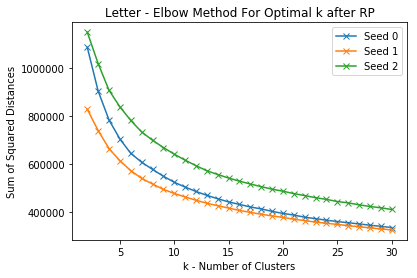

In [115]:
num_seeds = 3
for i in range(num_seeds):
    transformer = SparseRandomProjection(n_components=9, random_state=i)
    rp_projected_let = transformer.fit_transform(X_letter)

    K = range(2,31)
    ssd = get_sum_squared_distances(rp_projected_let, KMeans(n_clusters=2, random_state=i), K)

    plt.plot(K, ssd, marker='x', label='Seed '+str(i))
plt.legend(loc='best')
plt.xlabel('k - Number of Clusters')
plt.ylabel('Sum of Squared Distances')
plt.title('Letter - Elbow Method For Optimal k after RP')
plt.savefig('plots/RP/Letter/ssd.png')
plt.show()

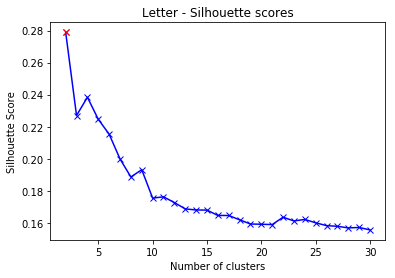

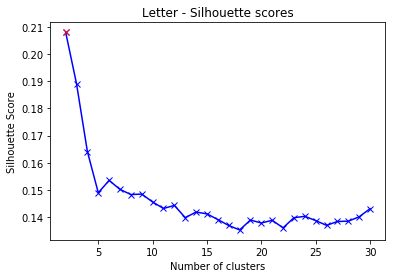

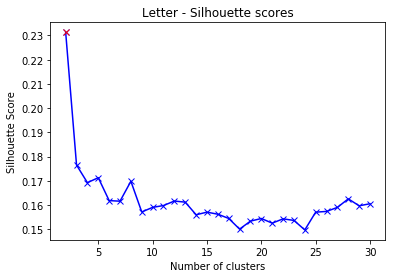

In [8]:
num_seeds = 3
for i in range(num_seeds):
    transformer = SparseRandomProjection(n_components=9, random_state=i)
    rp_projected_let = transformer.fit_transform(X_letter)
    
    path = 'plots/RP/Letter/sil-summary-kmeans-' + str(i) + '.png'
    silhouette_plot("KMeans", range(2,31), rp_projected_let, "Letter", i, path)

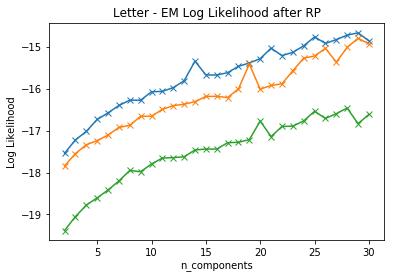

In [9]:
for i in range(num_seeds):
    transformer = SparseRandomProjection(n_components=9, random_state=i)
    rp_projected_let = transformer.fit_transform(X_letter)

    log_prob = np.zeros(29)
    n = np.arange(2,31)
    models = []
    #loop through each number of Gaussians and compute the Log Prob, and save the model
    for i,j in enumerate(n):
        #create mixture model with j components
        gmm = GMM(n_components=j)
        #fit it to the data
        gmm.fit(rp_projected_let)
        #compute the Log Prob for this model
        log_prob[i] = gmm.score(rp_projected_let)
        #add the best-fit model with j components to the list of models
        models.append(gmm)

    plt.plot(n, log_prob, marker='x', label='Seed '+ str(i))
    
plt.xlabel('n_components')
plt.ylabel('Log Likelihood')
plt.title('Letter - EM Log Likelihood after RP')
plt.savefig('plots/RP/Letter/loglik.png')
plt.show()

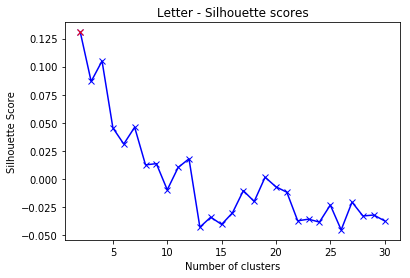

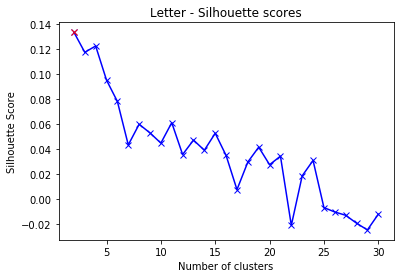

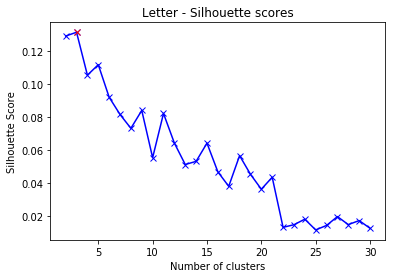

In [12]:
num_seeds = 3
for i in range(num_seeds):
    transformer = SparseRandomProjection(n_components=9, random_state=i)
    rp_projected_let = transformer.fit_transform(X_letter)
    
    path = 'plots/RP/Letter/sil-summary-gmm-' + str(i) + '.png'
    silhouette_plot("GMM", range(2,31), rp_projected_let, "Letter", i, path)

In [153]:
transformer = SparseRandomProjection(n_components=9, random_state=seed)
rp_projected_letter = transformer.fit_transform(X_letter)

training_x2D_letter_RP = TSNE(verbose=False, random_state=seed).fit_transform(rp_projected_letter)

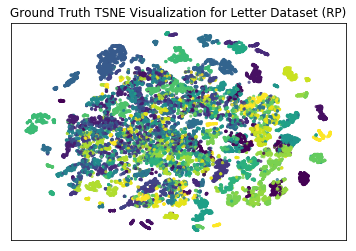

In [154]:
df = pd.DataFrame(np.hstack((training_x2D_letter_RP, np.atleast_2d(y_letter).T)), columns=['x','y','target'])
possible_clusters = list(set(df['target']))

plt.gca()
plt.title("Ground Truth TSNE Visualization for Letter Dataset (RP)")
plt.scatter(df['x'], df['y'], c=df['target'], alpha=0.7, s=5)
plt.xticks([])
plt.yticks([])
plt.grid(None)
plt.axis('tight')
plt.savefig('plots/RP/Letter/TSNE-groundtruth.png')
plt.show()

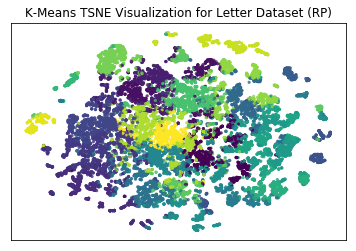

In [155]:
km = KMeans(n_clusters=25, init='k-means++', random_state=seed+1)
km = km.fit(rp_projected_letter)
y_pred_letter = km.labels_

df = pd.DataFrame(np.hstack((training_x2D_letter_RP, np.atleast_2d(y_pred_letter).T)), columns=['x','y','target'])
possible_clusters = list(set(df['target']))

plt.gca()
plt.title("K-Means TSNE Visualization for Letter Dataset (RP)")
plt.scatter(df['x'], df['y'], c=df['target'], alpha=0.7, s=5)
plt.xticks([])
plt.yticks([])
plt.grid(None)
plt.axis('tight')
plt.savefig('plots/RP/Letter/TSNE-kmeans.png')

plt.show()

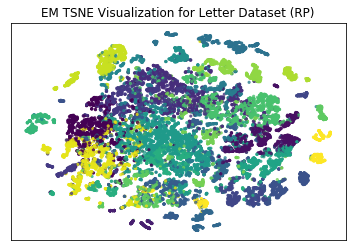

In [156]:
gmm = GMM(n_components=25, covariance_type='full', random_state=seed)
gmm = gmm.fit(rp_projected_letter)
y_pred_letter = gmm.predict(rp_projected_letter)

df = pd.DataFrame(np.hstack((training_x2D_letter_RP, np.atleast_2d(y_pred_letter).T)), columns=['x','y','target'])
possible_clusters = list(set(df['target']))

plt.gca()
plt.title("EM TSNE Visualization for Letter Dataset (RP)")
plt.scatter(df['x'], df['y'], c=df['target'], alpha=0.7, s=5)
plt.xticks([])
plt.yticks([])
plt.grid(None)
plt.axis('tight')
plt.savefig('plots/RP/Letter/TSNE-em.png')
plt.show()

### Bank

In [112]:
num_seeds = 50
ran_X_bank_dict = {}
for i in range(num_seeds):
    ran_X_bank_dict[i] = []
    
for state, dim in product(range(num_seeds), range(1, X_bank.shape[1]+1)):
    rp = SparseRandomProjection(random_state=state, n_components=dim)
    ran_X_bank_dict[state].append(rp.fit_transform(X_bank))

In [113]:
accuracies_bank = {}
for i in range(len(ran_X_bank_dict)):
    accuracies_bank[i] = []
    
n_feats = np.arange(1,X_bank.shape[1]+1)
for i in range(len(ran_X_bank_dict)):
    for X in ran_X_bank_dict[i]:
        acc = np.mean(cross_val_score(DecisionTreeClassifier(), X, y_bank, cv=5))
        accuracies_bank[i].append(acc)

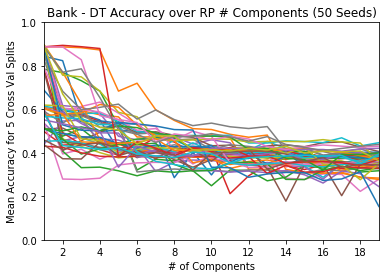

In [114]:
for i in range(len(accuracies_bank)):
    plt.plot(range(1,X_bank.shape[1]+1), accuracies_bank[i], label='Run ' + str(i))

plt.title('Bank - DT Accuracy over RP # Components (50 Seeds)')
plt.ylabel('Mean Accuracy for 5 Cross Val Splits')
plt.xlabel('# of Components')
plt.ylim(0,1)
plt.xlim(1,X_bank.shape[1])
plt.savefig('plots/RP/Bank/dt-component-analysis.png')
plt.show()

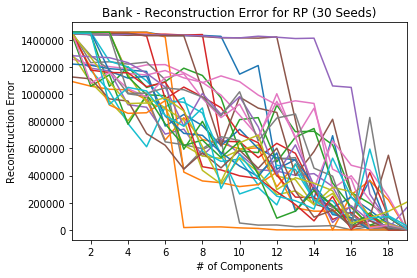

In [29]:
num_seeds = 30
recon_error = {}
for i in range(num_seeds):
    recon_error[i] = []
    
for state, dim in product(range(num_seeds), range(1, X_bank.shape[1]+1)):
        rp = SparseRandomProjection(n_components=dim, random_state=state)
        rp.fit(X_bank)
        recon_error[state].append(reconstruction_error(rp, X_bank))

for i in range(len(recon_error)):
    plt.plot(range(1,X_bank.shape[1]+1), recon_error[i])

plt.title('Bank - Reconstruction Error for RP (' + str(num_seeds) + ' Seeds)')
plt.xlabel('# of Components')
plt.ylabel('Reconstruction Error')
plt.xlim(1,X_bank.shape[1])
plt.savefig('plots/RP/Bank/reconstruction-error.png')
plt.show()

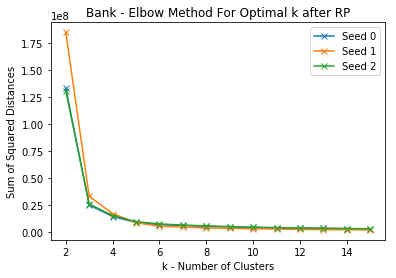

In [117]:
num_seeds = 3
for i in range(num_seeds):
    transformer = SparseRandomProjection(n_components=13, random_state=i)
    rp_projected_bank = transformer.fit_transform(X_bank)

    K = range(2,16)
    ssd = get_sum_squared_distances(rp_projected_bank, KMeans(n_clusters=2, random_state=i), K)

    plt.plot(K, ssd, marker='x', label='Seed '+str(i))
plt.legend(loc='best')
plt.xlabel('k - Number of Clusters')
plt.ylabel('Sum of Squared Distances')
plt.title('Bank - Elbow Method For Optimal k after RP')
plt.savefig('plots/RP/Bank/ssd.png')
plt.show()

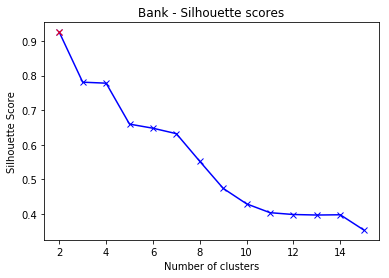

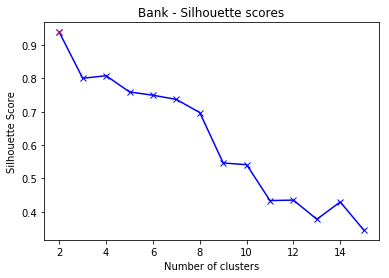

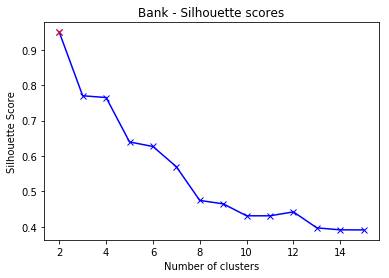

In [118]:
num_seeds = 3
for i in range(num_seeds):
    transformer = SparseRandomProjection(n_components=13, random_state=i)
    rp_projected_bank = transformer.fit_transform(X_bank)
    
    path = 'plots/RP/Bank/sil-summary-kmeans-' + str(i) + '.png'
    silhouette_plot("KMeans", range(2,16), rp_projected_bank, "Bank", i, path)

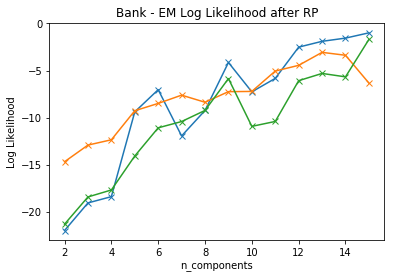

In [122]:
for i in range(num_seeds):
    transformer = SparseRandomProjection(n_components=13, random_state=i)
    rp_projected_let = transformer.fit_transform(X_bank)

    log_prob = np.zeros(14)
    n = np.arange(2,16)
    models = []
    #loop through each number of Gaussians and compute the Log Prob, and save the model
    for i,j in enumerate(n):
        #create mixture model with j components
        gmm = GMM(n_components=j)
        #fit it to the data
        gmm.fit(rp_projected_let)
        #compute the Log Prob for this model
        log_prob[i] = gmm.score(rp_projected_let)
        #add the best-fit model with j components to the list of models
        models.append(gmm)

    plt.plot(n, log_prob, marker='x', label='Seed '+ str(i))
    
plt.xlabel('n_components')
plt.ylabel('Log Likelihood')
plt.title('Bank - EM Log Likelihood after RP')
plt.savefig('plots/RP/Bank/loglik.png')
plt.show()

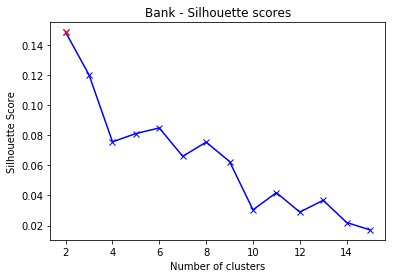

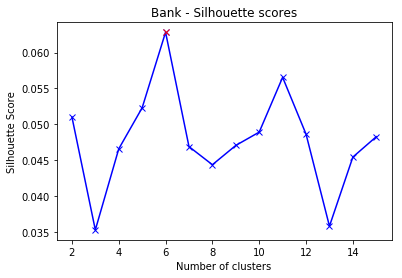

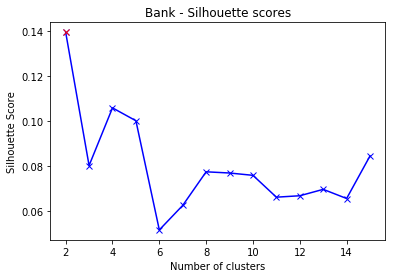

In [119]:
num_seeds = 3
for i in range(num_seeds):
    transformer = SparseRandomProjection(n_components=13, random_state=i)
    rp_projected_bank = transformer.fit_transform(X_letter)
    
    path = 'plots/RP/Bank/sil-summary-gmm-' + str(i) + '.png'
    silhouette_plot("GMM", range(2,16), rp_projected_bank, "Bank", i, path)

In [120]:
transformer = SparseRandomProjection(n_components=13, random_state=seed)
rp_projected_bank = transformer.fit_transform(X_bank)

training_x2D_bank_RP = TSNE(verbose=False, random_state=seed).fit_transform(rp_projected_bank)

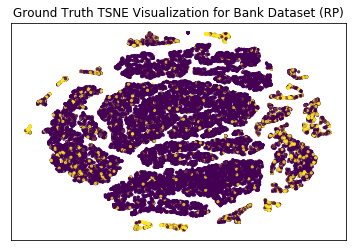

In [121]:
df = pd.DataFrame(np.hstack((training_x2D_bank_RP, np.atleast_2d(y_bank).T)), columns=['x','y','target'])
possible_clusters = list(set(df['target']))

plt.gca()
plt.title("Ground Truth TSNE Visualization for Bank Dataset (RP)")
plt.scatter(df['x'], df['y'], c=df['target'], alpha=0.7, s=5)
plt.xticks([])
plt.yticks([])
plt.grid(None)
plt.axis('tight')
plt.savefig('plots/RP/Bank/TSNE-groundtruth.png')
plt.show()

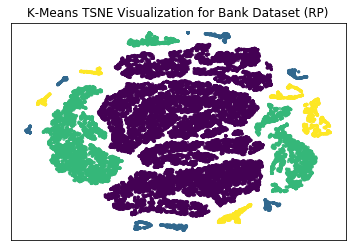

In [124]:
km = KMeans(n_clusters=4, init='k-means++', random_state=seed)
km = km.fit(rp_projected_bank)
y_pred_bank = km.labels_

df = pd.DataFrame(np.hstack((training_x2D_bank_RP, np.atleast_2d(y_pred_bank).T)), columns=['x','y','target'])
possible_clusters = list(set(df['target']))

plt.gca()
plt.title("K-Means TSNE Visualization for Bank Dataset (RP)")
plt.scatter(df['x'], df['y'], c=df['target'], alpha=0.7, s=5)
plt.xticks([])
plt.yticks([])
plt.grid(None)
plt.axis('tight')
plt.savefig('plots/RP/Bank/TSNE-kmeans.png')

plt.show()

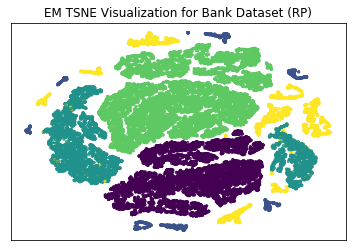

In [126]:
gmm = GMM(n_components=5, covariance_type='full', random_state=seed)
gmm = gmm.fit(rp_projected_bank)
y_pred_bank = gmm.predict(rp_projected_bank)

df = pd.DataFrame(np.hstack((training_x2D_bank_RP, np.atleast_2d(y_pred_bank).T)), columns=['x','y','target'])
possible_clusters = list(set(df['target']))

plt.gca()
plt.title("EM TSNE Visualization for Bank Dataset (RP)")
plt.scatter(df['x'], df['y'], c=df['target'], alpha=0.7, s=5)
plt.xticks([])
plt.yticks([])
plt.grid(None)
plt.axis('tight')
plt.savefig('plots/RP/Bank/TSNE-em.png')
plt.show()

## Random Forest Clustering

### Letter

In [32]:
rfc = RandomForestClassifier(n_estimators=100,class_weight='balanced',random_state=seed)
fs_letter = rfc.fit(X_letter,y_letter).feature_importances_ 

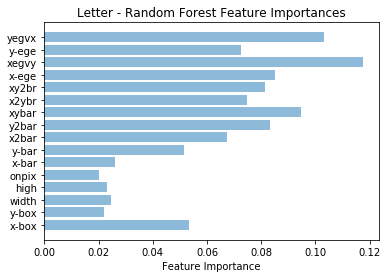

In [33]:
pos = np.arange(len(fs_letter))
plt.barh(pos, fs_letter, align='center', alpha=0.5)
plt.yticks(pos, letter_headers)
plt.xlabel('Feature Importance')
plt.title('Letter - Random Forest Feature Importances')
plt.savefig('plots/RF/Letter/features-importances.png')
plt.show()

In [116]:
let_thres = np.mean(fs_letter) - (0.5*np.std(fs_letter))
rf_X_letter = X_letter[:, fs_letter >= let_thres]
print (X_letter.shape)
print (rf_X_letter.shape)

(20000, 16)
(20000, 11)


In [157]:
K = range(2,51)
ssd = get_sum_squared_distances(rf_X_letter, KMeans(n_clusters=2, random_state=seed), K)
plt.plot(K, ssd, 'bx-')
plt.xlabel('k - Number of Clusters')
plt.ylabel('Sum of Squared Distances')
plt.title('Letter - Elbow Method For Optimal k after RF Reduction')
plt.savefig('plots/RF/Letter/ssd.png')
plt.show()

NameError: name 'rf_X_letter' is not defined

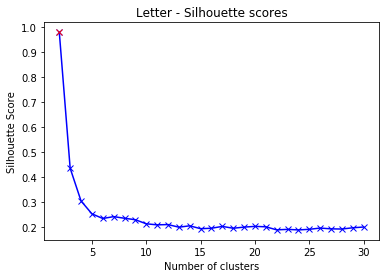

In [132]:
path = 'plots/RF/Letter/sil-summary-kmeans.png'
silhouette_plot("KMeans", range(2,31), rp_projected_bank, "Letter", seed, path)

In [ ]:
n_components = np.arange(2, 51)
models = [GMM(n, covariance_type='full', random_state=seed).fit(rf_X_letter)
          for n in n_components]

plt.title("Letter - Log Likelihood over # of components (GMM, RF)")
plt.plot(n_components, [m.score(rf_X_letter) for m in models], label='log likelihood')
plt.legend(loc='best')
plt.xlabel('# of components')
plt.ylabel('Log Likelihood')
plt.savefig('plots/RF/Letter/loglik.png')
plt.show()

In [ ]:
plt.plot(n_components, [m.bic(rf_X_letter) for m in models], label='BIC')
plt.plot(n_components, [m.aic(rf_X_letter) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('# of components')
plt.ylabel('BIC/AIC Score')
plt.title('Letter - RF Reduction EM BIC/AIC Score')
plt.show()

In [136]:
training_x2D_letter_RF = TSNE(verbose=False, random_state=seed).fit_transform(rf_X_letter)

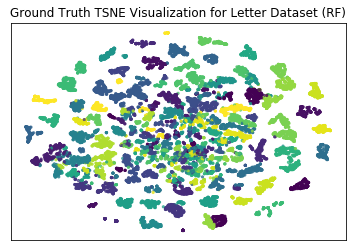

In [143]:
df = pd.DataFrame(np.hstack((training_x2D_letter_RF, np.atleast_2d(y_letter).T)), columns=['x','y','target'])
possible_clusters = list(set(df['target']))

plt.gca()
plt.title("Ground Truth TSNE Visualization for Letter Dataset (RF)")
plt.scatter(df['x'], df['y'], c=df['target'], alpha=0.7, s=5)
plt.xticks([])
plt.yticks([])
plt.grid(None)
plt.axis('tight')
plt.savefig('plots/RF/Letter/TSNE-groundtruth.png')
plt.show()

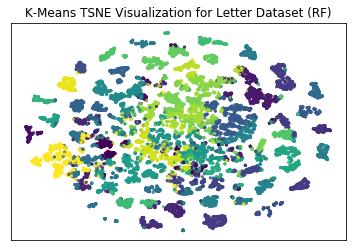

In [144]:
km = KMeans(n_clusters=30, init='k-means++', random_state=seed)
km = km.fit(rf_X_letter)
y_pred_let = km.labels_

df = pd.DataFrame(np.hstack((training_x2D_letter_RF, np.atleast_2d(y_pred_let).T)), columns=['x','y','target'])
possible_clusters = list(set(df['target']))

plt.gca()
plt.title("K-Means TSNE Visualization for Letter Dataset (RF)")
plt.scatter(df['x'], df['y'], c=df['target'], alpha=0.7, s=5)
plt.xticks([])
plt.yticks([])
plt.grid(None)
plt.axis('tight')
plt.savefig('plots/RF/Letter/TSNE-kmeans.png')

plt.show()

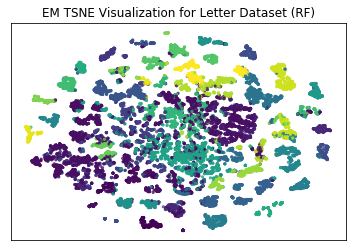

In [145]:
gmm = GMM(n_components=27, covariance_type='full', random_state=seed)
gmm = gmm.fit(rf_X_letter)
y_pred_let = gmm.predict(rf_X_letter)

df = pd.DataFrame(np.hstack((training_x2D_letter_RF, np.atleast_2d(y_pred_let).T)), columns=['x','y','target'])
possible_clusters = list(set(df['target']))

plt.gca()
plt.title("EM TSNE Visualization for Letter Dataset (RF)")
plt.scatter(df['x'], df['y'], c=df['target'], alpha=0.7, s=5)
plt.xticks([])
plt.yticks([])
plt.grid(None)
plt.axis('tight')
plt.savefig('plots/RF/Letter/TSNE-em.png')
plt.show()

## Bank

In [30]:
rfc = RandomForestClassifier(n_estimators=100,class_weight='balanced',random_state=seed)
fs_bank = rfc.fit(X_bank,y_bank).feature_importances_ 

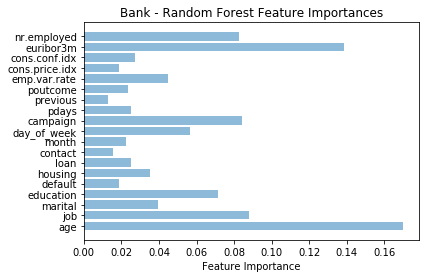

In [31]:
pos = np.arange(len(fs_bank))
plt.barh(pos, fs_bank, align='center', alpha=0.5)
plt.yticks(pos, bank_headers)
plt.xlabel('Feature Importance')
plt.title('Bank - Random Forest Feature Importances')
plt.savefig('plots/RF/Bank/feats.png')
plt.show()

In [131]:
bank_thres = np.mean(fs_bank)
rf_X_bank = X_bank[:, fs_bank >= bank_thres]
print (X_bank.shape)
print (rf_X_bank.shape)

(41188, 19)
(41188, 7)


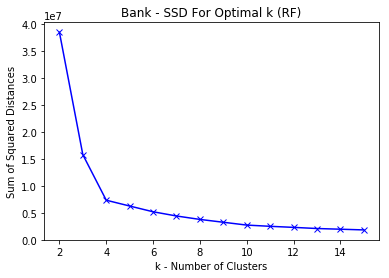

In [133]:
K = range(2,16)
ssd = get_sum_squared_distances(rf_X_bank, KMeans(n_clusters=2, random_state=seed), K)
plt.plot(K, ssd, 'bx-')
plt.xlabel('k - Number of Clusters')
plt.ylabel('Sum of Squared Distances')
plt.title('Bank - SSD For Optimal k (RF)')
plt.savefig('plots/RF/Bank/ssd.png')
plt.show()

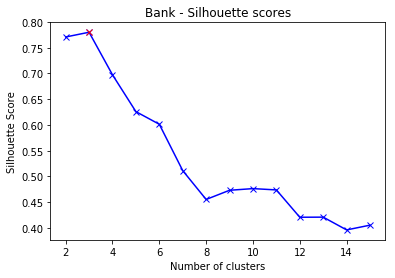

In [134]:
path = 'plots/RF/Bank/sil-summary-kmeans.png'
silhouette_plot("KMeans", range(2,16), rf_X_bank, "Bank", seed, path)

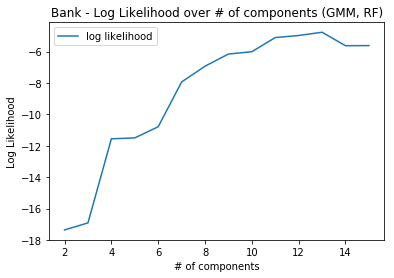

In [135]:
n_components = np.arange(2, 16)
models = [GMM(n, covariance_type='full', random_state=seed).fit(rf_X_bank)
          for n in n_components]

plt.title("Bank - Log Likelihood over # of components (GMM, RF)")
plt.plot(n_components, [m.score(rf_X_bank) for m in models], label='log likelihood')
plt.legend(loc='best')
plt.xlabel('# of components')
plt.ylabel('Log Likelihood')
plt.savefig('plots/RF/Bank/loglik.png')
plt.show()

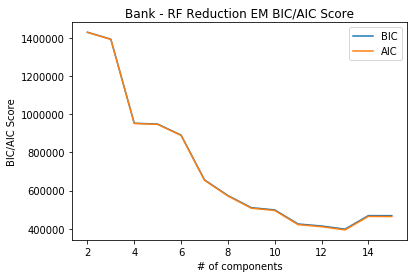

In [136]:
plt.plot(n_components, [m.bic(rf_X_bank) for m in models], label='BIC')
plt.plot(n_components, [m.aic(rf_X_bank) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('# of components')
plt.ylabel('BIC/AIC Score')
plt.title('Bank - RF Reduction EM BIC/AIC Score')
plt.savefig('plots/RF/Bank/bic-aic.png')
plt.show()

In [137]:
training_x2D_bank_RF = TSNE(verbose=False, random_state=seed).fit_transform(rf_X_bank)

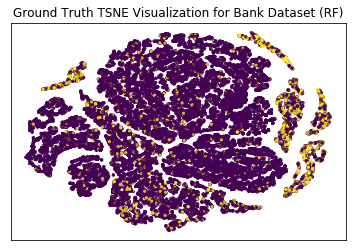

In [138]:
df = pd.DataFrame(np.hstack((training_x2D_bank_RF, np.atleast_2d(y_bank).T)), columns=['x','y','target'])
possible_clusters = list(set(df['target']))

plt.gca()
plt.title("Ground Truth TSNE Visualization for Bank Dataset (RF)")
plt.scatter(df['x'], df['y'], c=df['target'], alpha=0.7, s=5)
plt.xticks([])
plt.yticks([])
plt.grid(None)
plt.axis('tight')
plt.savefig('plots/RF/Bank/TSNE-groundtruth.png')
plt.show()

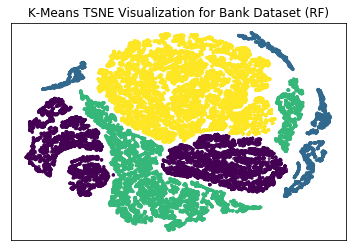

In [139]:
km = KMeans(n_clusters=4, init='k-means++', random_state=seed)
km = km.fit(rf_X_bank)
y_pred_bank = km.labels_

df = pd.DataFrame(np.hstack((training_x2D_bank_RF, np.atleast_2d(y_pred_bank).T)), columns=['x','y','target'])
possible_clusters = list(set(df['target']))

plt.gca()
plt.title("K-Means TSNE Visualization for Bank Dataset (RF)")
plt.scatter(df['x'], df['y'], c=df['target'], alpha=0.7, s=5)
plt.xticks([])
plt.yticks([])
plt.grid(None)
plt.axis('tight')
plt.savefig('plots/RF/Bank/TSNE-kmeans.png')

plt.show()

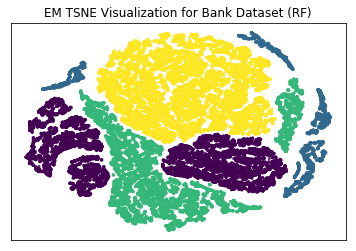

In [140]:
gmm = GMM(n_components=4, covariance_type='full', random_state=seed)
gmm = gmm.fit(rf_X_bank)
y_pred_bank = gmm.predict(rf_X_bank)

df = pd.DataFrame(np.hstack((training_x2D_bank_RF, np.atleast_2d(y_pred_bank).T)), columns=['x','y','target'])
possible_clusters = list(set(df['target']))

plt.gca()
plt.title("EM TSNE Visualization for Bank Dataset (RF)")
plt.scatter(df['x'], df['y'], c=df['target'], alpha=0.7, s=5)
plt.xticks([])
plt.yticks([])
plt.grid(None)
plt.axis('tight')
plt.savefig('plots/RF/Bank/TSNE-em.png')
plt.show()